# Emotion Recognize

In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function
from IPython.display import Image as ipImage, display
import matplotlib.pyplot as plt
%matplotlib inline 

_url = 'https://westus.api.cognitive.microsoft.com/emotion/v1.0/recognize'
_key = 'Insira sua chave aqui!'
_maxNumRetries = 10

## Helper function

Processa a requisição para a API

#### Parameters:
* json: Used when processing images from its URL. See API Documentation
* data: Used when processing image read from disk. See API Documentation
* headers: Used to pass the key information and the data type request

In [2]:
def processRequest( json, data, headers, params ):
    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

### Função para exibir o resultado na imagem

In [3]:
def renderResultOnImage( result, img ):
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )

    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 2 )

# Exibir a imagem

In [4]:
urlImage = 'https://meriatblob.blob.core.windows.net/demos/cognitive/faces.jpeg'

img = ipImage(url=urlImage, width=800)
display(img)

# Detectar faces de uma imagem via URL

In [5]:
headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None
params = None

result = processRequest( json, data, headers, params )

# Exibir o resultado

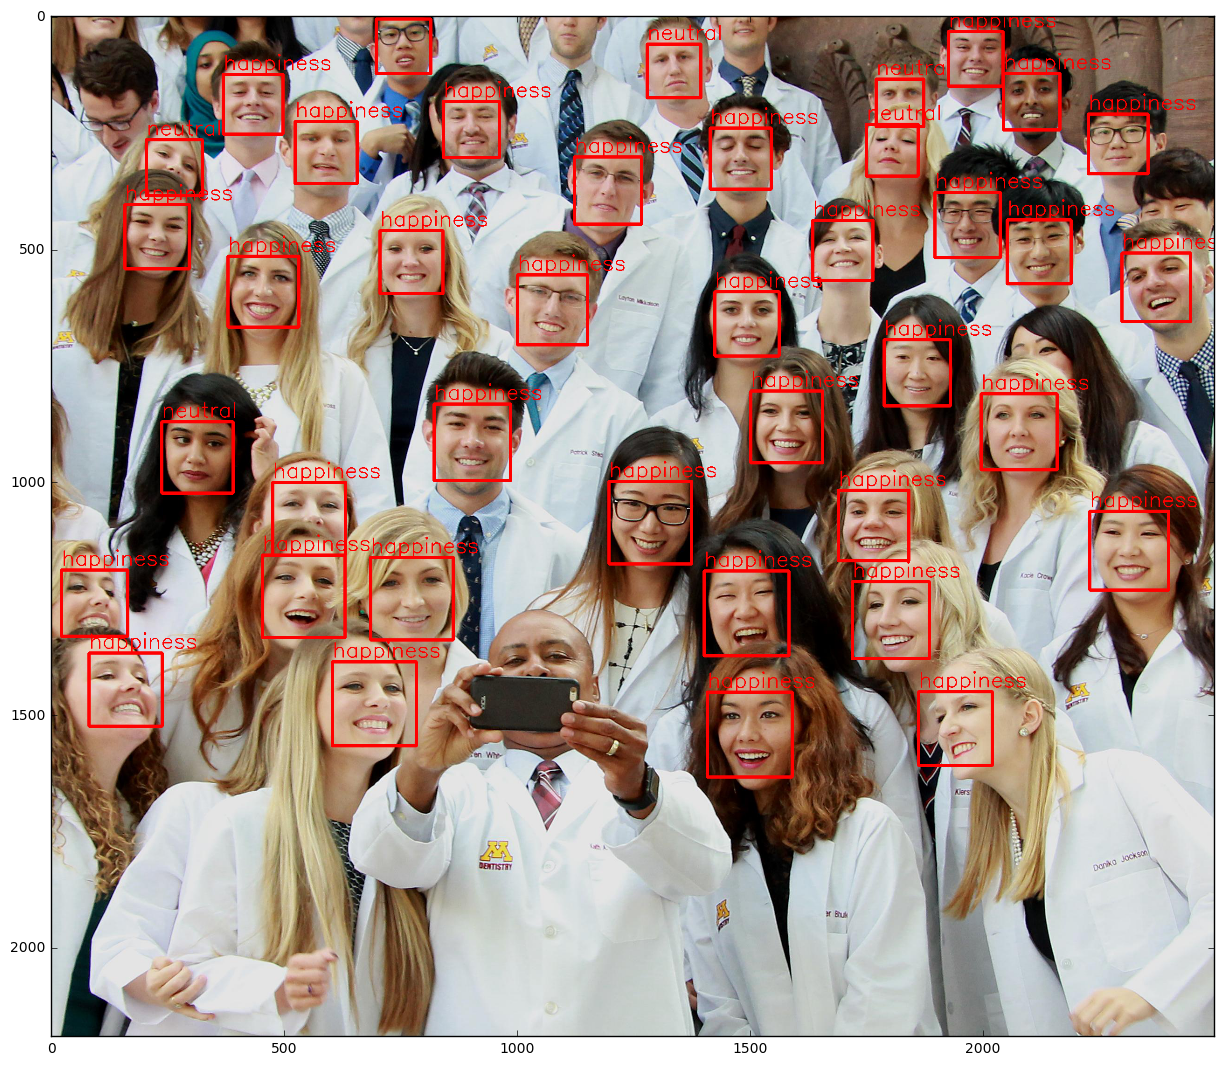

In [6]:
if result is not None:
    # Carrega a imagem original para desenhar o conteúdo
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )